# CarND-Vehicle Detection
Here is the code and documentation for the project that I did for Udacity Self-Driving car class- Project 5.
In this document, I explain all of the steps taken one by one.

#Vehicle Detection Project

The goals / steps of this project are the following:

1-Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier<br/>
2-Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.<br/>
3-Implement a sliding-window technique and use your trained classifier to search for vehicles in images.<br/>
4-Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.<br/>
5-Estimate a bounding box for vehicles detected.<br/>


## Step 0-Loading Modules<br />
Nothing special here, just loading modules that we will need for this project.<br />

In [1]:
import os
import cv2
import math
import glob
import time
import numpy as np
import matplotlib.image as mpimg
from skimage.feature import hog
import matplotlib.pyplot as plt
from IPython.display import HTML
from sklearn.svm import LinearSVC
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
%matplotlib inline

## 1.Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
Here I define couple of functions that can be used later for this project.<br/>

get_hog_festures function:<br/>
The first function is get_hog_festures. This function gets an image, number of orientations,pixels per cell and cell per block as input and uses hog function from skimage.feature to perform Histogram of Oriented Gradients (HOG) returns features as output. The get_hog_festures also gets vis state and if it is true it also returns the visualization of the HOG features and also. The feature_vec also indicates if we want to ravel the data to a vector form.<br/>
bin_spatial function:<br/>
This function resizes an image and ravels the data into a vector form using cv2 resize function and then ravel functin.<br/>
color_hist function:<br/>
This function gets an image and number of bins as input and then finds histogram of different channels in indicated number of bins and then concatenates them and returns it as vector.<br/>

Now that we have these 3 functions, we will combine them all in one function to perform all 3 steps in 1 function call.<br/>
extract_features function:<br/>
This function is combination of above mentioned functions. It gets a list of images and also all of the above mentioned inputs. It also gets color sapce that is the space that we want to use for applying these 3 functions and also hog channel that indicates on what channel of color space we want to apply feature extraction. After converting the color channel to desired channel based on the input,it checks what function among above mentioned functions should be used for building the output based on input choices. then it concatenates them and returns them as output.


In [2]:

#  A function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Calls with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise calls with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# A function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Returns the feature vector
    return features

# A function to compute color histogram features 
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenates the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Returns the individual histograms, bin_centers and feature vector
    return hist_features

# A function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(64, 64),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Creates a list to append feature vectors to
    features = []
    # Iterates through the list of images
    for file in imgs:
        file_features = []
        # Reads in each one by one
        image = mpimg.imread(file)
        # applies color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Applies color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Calls get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Appends the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Returns list of feature vectors
    return features


### Reading Training Images and Presenting HOG Results<br/>
Here I use glob module to get list of all images in different folders and add them to the lists of cars and notcars.Then I read one from each and apply get_hog_featurs with visualization True and present the result. As it can be seen in the presented result, HOG of a car shows features that is much closer to car comparing with an image that does not contain a car in it.

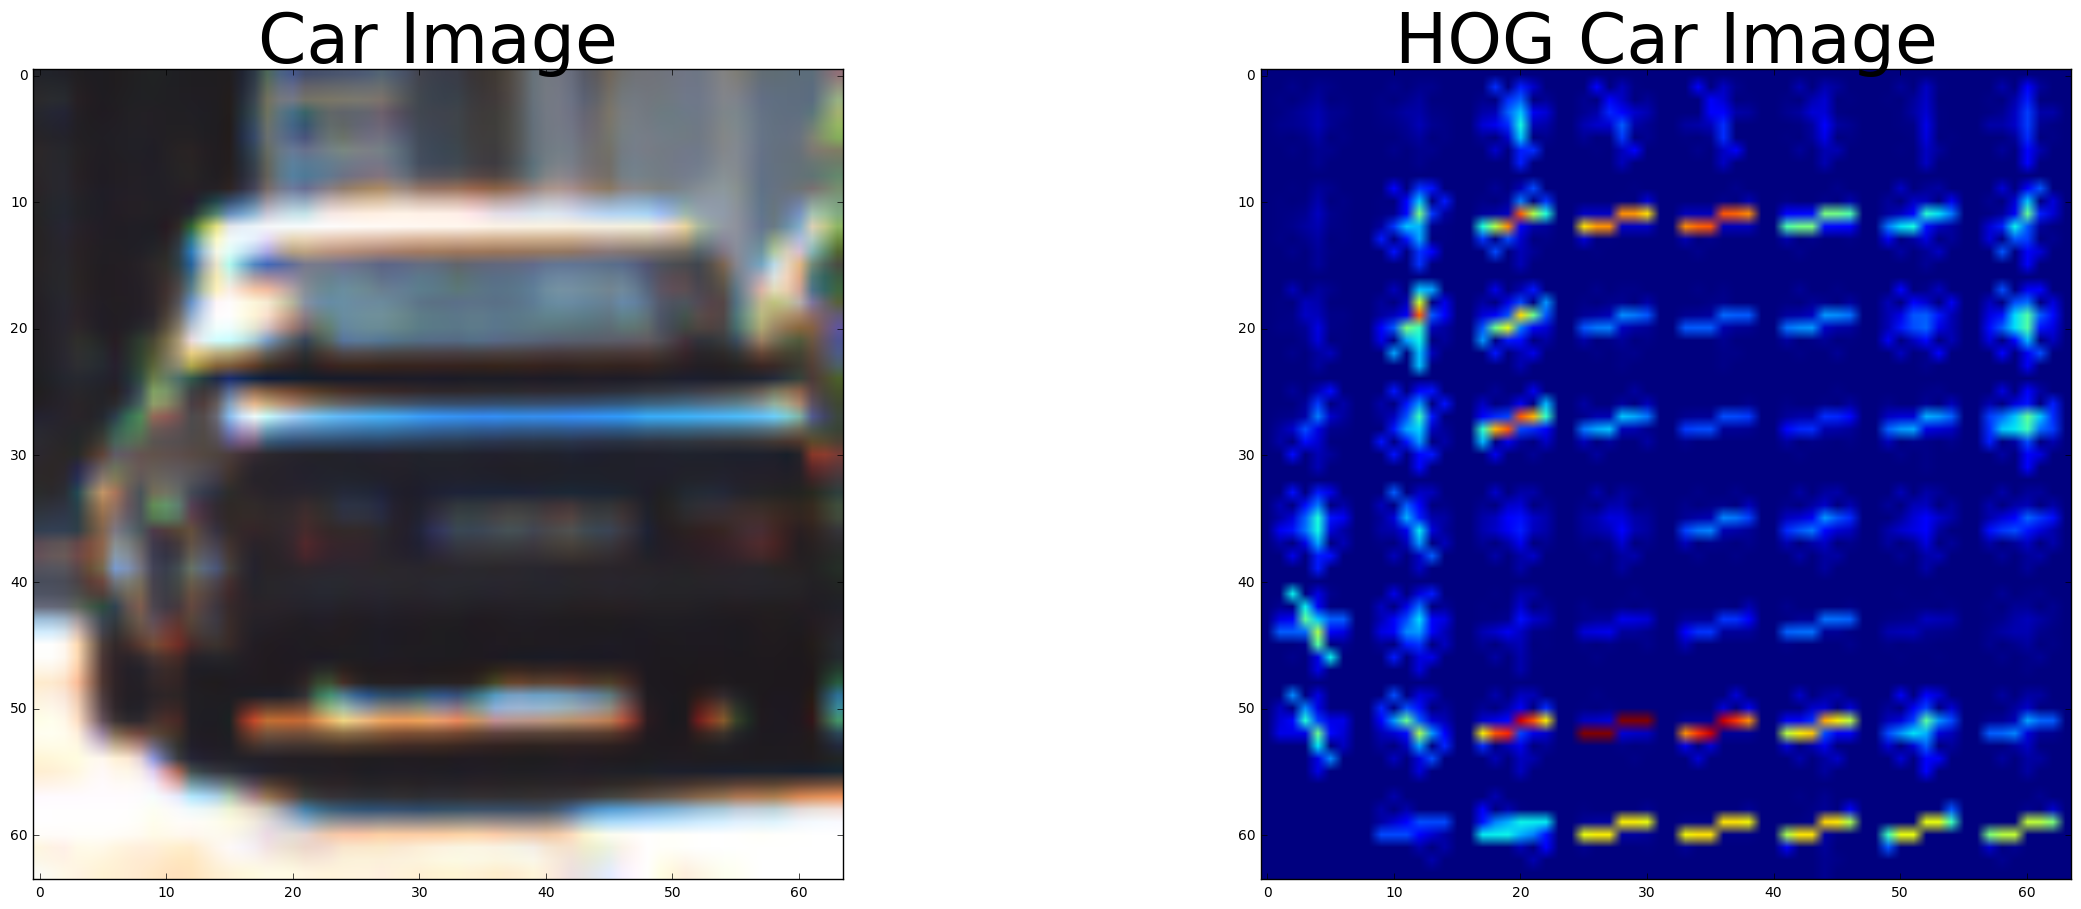

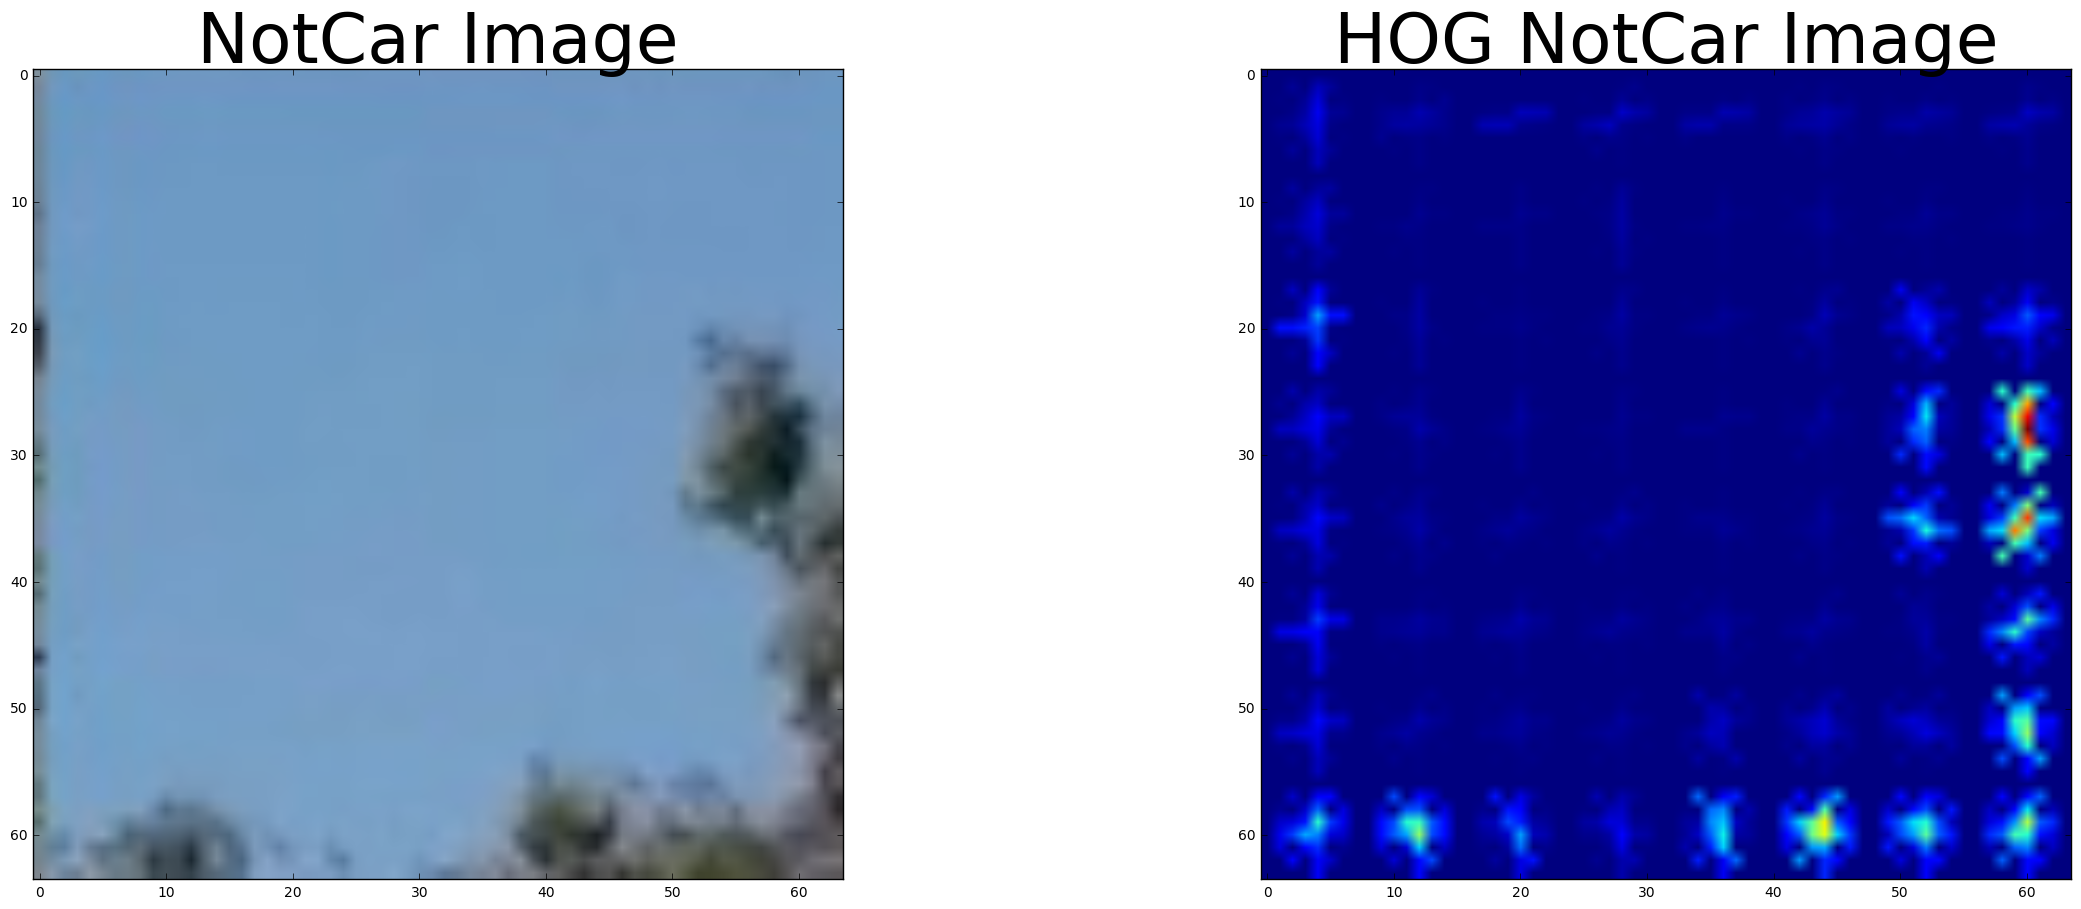

In [3]:
#reading all images
images_Kitti = glob.glob('vehicles/KITTI_extracted/*.png')
images_GTIFar = glob.glob('vehicles/GTI_Far/*.png')
images_GTILeft = glob.glob('vehicles/GTI_Left/*.png')
images_GTIMiddleClose = glob.glob('vehicles/GTI_MiddleClose/*.png')
images_GTIRight = glob.glob('vehicles/GTI_Right/*.png')
images_extra = glob.glob('non-vehicles/extras/*.png')
images_GTI = glob.glob('non-vehicles/GTI/*.png')
### car images
cars = []
cars.extend(images_Kitti)
cars.extend(images_GTIFar)
cars.extend(images_GTILeft)
cars.extend(images_GTIMiddleClose)
cars.extend(images_GTIRight)
#noncar images
notcars = []
notcars.extend(images_extra)
notcars.extend(images_GTI)


image_car = mpimg.imread(cars[0])
image_notcar = mpimg.imread(notcars[0])
car_featur,hog_carimage=get_hog_features(image_car[:,:,0],orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)
notcar_featur,hog_notcarimage=get_hog_features(image_notcar[:,:,0],orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)

#Showing Car image and related HOG

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_car)
ax1.set_title('Car Image', fontsize=50)
ax2.imshow(hog_carimage)
ax2.set_title('HOG Car Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#Showing NotCar image and related HOG
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_notcar)
ax1.set_title('NotCar Image', fontsize=50)
ax2.imshow(hog_notcarimage)
ax2.set_title('HOG NotCar Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



### Training SVC<br/>
Training our model to classify images is a trial and error porcess and we want to gain maximum accuracy for our training.<br/>
To accomplish this, first, I define prameters needed for this training. Then I prepare input for my model. To do so, I call extract_features function on both cars and notcars and then I stack them vertically.<br/> Before feeding this to the training process, we need to make sure that our data is scalled properly otherwise if the scale of two categoris is bigger, it might dominate the result. To achieve this, first we need to convert data to float64 and then we feed our data X to StandardScaler().fit(X) to find the scale and then X_scaler.transform(X) will apply scalling to our data.<br/>
We also need to tell our classifier what is the correct category of our input data. To do so, I make  vector with lenght of cars made of ones and another vector with lenght of notcars made of zeros and I stack them horizantally.<br/>
The next step is splitting our data to train and test data. I used train_test_split from sklearn to seprate 20% of our input data as test data.I also use random state of this function to make sure output from this function is shuffled.<br/>
Now it is time to train our model.I used Support Vector Clsassification (SVC) as my main training approach. I used LinearSVC() as classifier and fit to train and score to test the accuracy of classification and I also present them.<br/>
Next step is chosing best parameters for our classifier.This step took several days for me. I have tried many different color spaces including RGB, HSV, LUV, HLS, YUV, YCrCb. I also tried only one channel or all channels of these color spaces. My investigation showed that using only one channel results in training accuracy between 95% to 98%. Using all channels always resulted in accuracy higher than 99% with YCrCb and HSV being the highest aroun 99.3% in average. Here I used YCrCb as color space and I use all chanels.I also found that choosing number of orientations as 9 is the best. lower values decreases the accuracy and higher values does not increase accuracy but increases training time drastically. I also selected pixel per cell and cell per block 8 and 2 respectively I chose spatial size (16,16) and hist_bins also as 16. For this training I used all 3 spatial binning, histogram of colors and also HOG to extract featurs.<br/>

In [4]:
#### Train SVC
## Extracting features parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#Extracting cars features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
#Extracting Notcars features
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

#Combining data
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Applies the scaler to X
scaled_X = X_scaler.transform(X)
# The labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Splits up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# A linear SVC 
svc = LinearSVC()
# Present the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Checks the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
29.85 Seconds to train SVC...
Test Accuracy of SVC =  0.993


## 3-Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
Here is the find_cars function that takes an image,parameters for  range of image that we want to look for a car,HOG parameters, scale of the window and classifier and scaler.This functions outputs a list of boxes that a car is found in.<br/>
In this function, I first define an empty list to store boxes in. Then I change the scale of the image matrix values to be between 0 and 1 and consistent with training. Then I crop the vertical range defined by ystart and ystop and also change color space to match the training color space.<br/>
Now we can take 2 different approaches. We can select a window in the image and calculate the HOG and other features and extract them and check if there is car in the window. Or we can take the HOG and other features or the whole image and then check if there is a car in scaled windows.I select later becuase it is much faster since we only extract features for the whole image once.<br/>
Then I check the scale. Scale here indicates size of the window or in reality if window size is constant, what is the scale to enlarge the HOG to mimic increasing certain window size. If scale is not one, we need to scale our image.<br/>
Now we want to extract features in the same orde that we did for training.<br/>
So we start from color. I separate different color channels.Then I find number of blocks in x and y directions based on pixel per cell and cell per block and then how many blocks we use to step. Here I chose 2 cells per step that equals to 75% overlap. With this we can calculate how many steps totally we need to take in x and y direction<br/>
Then I use two nested loops and search for the image in each step. TO do so, for each window,I calculate HOG for different color channels, then for spatial binning and then histogram of colors and then stack them horizontally.<br/>
Then we need to make sure that our data is correctly scaled. So I scale this vector with same scaler that we used for training our classifier.Then we feed this scaled data to our trained classifier and if the perdiction shows existance of a car we add that window to our list of boxes and if not we just pass to next window.<br>
I also define a helpfull function draw_boxes that takes an image and list of boxes and draws all boxes in list on the image. I use this to visualize one sample.

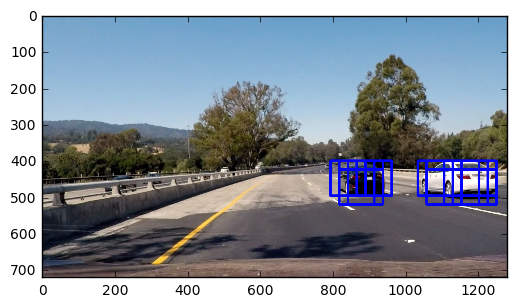

In [6]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,vis=True):
    
    img_boxes=[]
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                img_boxes.append(((xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return img_boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
ystart = 400
ystop = 656
scale=1.5
img = mpimg.imread('test_images_original/test4.jpg')
img_boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,vis=True)
draw_img = np.copy(img)
out_img=draw_boxes(img,img_boxes)

plt.imshow(out_img)


Next we need to be able to combine all of the boxes and also have measure where are the boxes and how many times a car has been detected in a place.<br/>
So I define add_heat that takes an image and list of boxes and returns an image with same size of the input image showing heatmap of the location of cars found in an image.

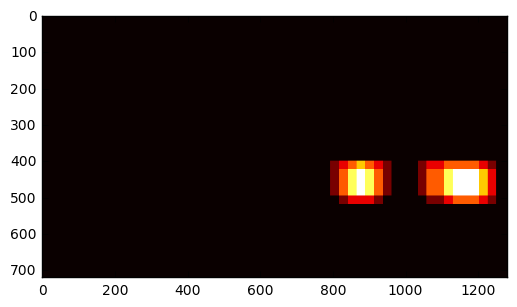

In [7]:
def add_heat(heatmap, box_list):
    # Makes a copy of image with all values equal to 0
    heatmap=np.zeros_like(img[:,:,0])
    # Iterates through list of bboxes
    for box in box_list:
        #print(box)
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
heated=add_heat(img,img_boxes)
plt.imshow(heated,cmap='hot')


In the next step, we want to apply a threshhold to our heatmap. This can help getting rid of noise and false detections.<br/>
Then I use label function to combine and find one box for each location of the car and then I define another function draw_labeled_bboxes that uses these labels to draw a box on the originasl image.The result is demonstrated below

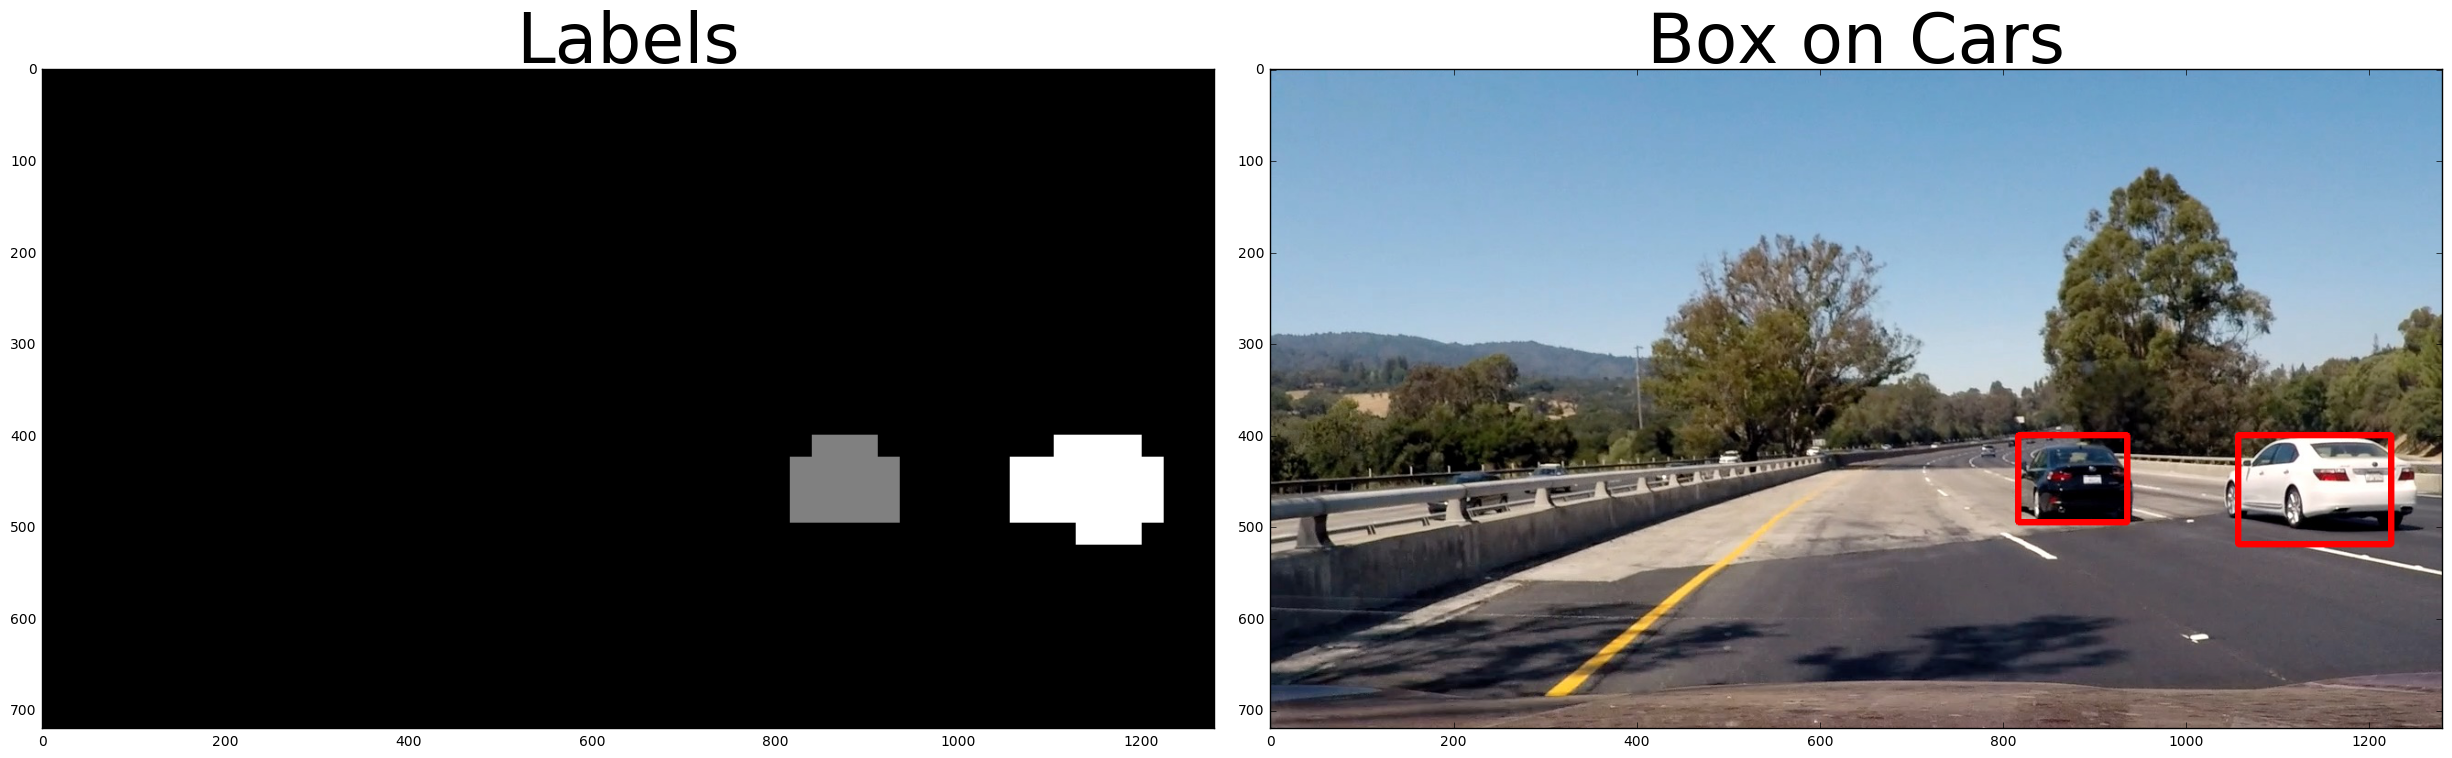

In [11]:
def apply_threshold(heatmap, threshold):
    heated=np.copy(heatmap)
    # Zero out pixels below the threshold
    heated[heated <= threshold] = 0
    # Return thresholded map
    return heated
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #car.heatmap.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

cooled=apply_threshold(heated,2)
labels = label(cooled)
final_image = draw_labeled_bboxes(np.copy(img), labels)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(labels[0], cmap='gray')
ax1.set_title('Labels', fontsize=50)
ax2.imshow(final_image)
ax2.set_title('Box on Cars', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 4-Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
## 5-Estimate a bounding box for vehicles detected.<br/>
Now it's time to combine all of these steps together.So I define process_image function that takes an image as input and outputs an image with boxes added to classified cars.<br/>
I also define Vehicle class to store heatmap of each frame.<br/>
In process_image function, I define range in the image that we want to search for a car.I also define 3 different scales for our find_cars function and run this function with all 3 scales and add all of the resulted boxes will be appended to a list of boxes.<br/>
Then I make a heatmap of this identified boxes and then I apply threshold ot 1 them.Then I append this heatmap to vehicle class instsnce (car) heatmap variable.<br/>
Next, I sum heatmap of last 10 frames, and apply threshold of 8 to them. This means the car must have been detected at least 8 times in last 10 frames to exist in final result. Then I use label function and draw_labeled_bboxes function to draw boxes in original image and then I return this image as output.Applying these two thresholds will reduce probablity of a false detection and noise to pop up in final result and filters unwanted detections.<br/>
Just one point to mention is, since for a single image there is no 10 previous frames, applying this function will not show any car. For applying to  single image we can simply delete this sum and thresholding among frames part<br/>
In next cell, I just pass this function to clip1.fl_image. This functions reads the video frame by frame and for each frame it runs process_image and gets the output frames and attach them together as an output video.

In [19]:
class Vehicle():
    def __init__(self):
        self.heatmap=[]
car=Vehicle()
car.heatmap=[]
def process_image(img):
    # Creates Empty lists
    heatmap=[]
    heated=np.zeros_like(img[:,:,0])
    # Defines vertical range in an image to look for a car
    ystart = 400
    ystop = 656
    # List of scales used
    scale_all=[1,1.5,2]
    # Loops through scales and adds all of the result to heatmap
    for scale in scale_all:
        out_boxes=find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        heatmap.append(add_heat(img,out_boxes))
    # Adds all of the heatmaps for different scales
    heated=np.sum(heatmap,axis=0)
    # Applies threshold to heatmaps
    heated_thresh=apply_threshold(heated,1)
    # Adds filtered heatmap to Car class heatmap variable
    car.heatmap.append(heated_thresh)
    # Adds all of the heatmaps for last 10 frames
    heat_avg=np.sum(car.heatmap[-10:],axis=0)
    # Applies threshold of 8 to the last 10 frames stored 
    avg_cooled=apply_threshold(heat_avg,8)
    labels = label(avg_cooled)
    final_image = draw_labeled_bboxes(np.copy(img), labels)
    return final_image



In [20]:
# Makes sure heatmap is empty and there is no data from previous runs saved
car.heatmap=[]
# Output video Name
white_output = 'Project_Output_Final.mp4'
#Input Video
clip1 = VideoFileClip("project_video.mp4")
# Reads frame by frame and applies process image to each frame and outputs them as a video
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)
print('done')

[MoviePy] >>>> Building video Project_Output_Final.mp4
[MoviePy] Writing video Project_Output_Final.mp4


100%|█████████▉| 1260/1261 [30:38<00:01,  1.83s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Project_Output_Final.mp4 

CPU times: user 26min 20s, sys: 1min 37s, total: 27min 58s
Wall time: 30min 40s
done


## Discussion
As mentioned above the pipeline here has two parts. In part one:
Loading our training data--> extracting features: color histogram/spatial binning/HOG--> combining the features--> scale data--> split data to training and test-->shuffle data-->train classifier--> test classifier
In part two, we want to utilize the classifier to detect cars in each frame and the pipeline is:
load each frame--> extract HOG/histogram of colors/spatial binning features-->slide a window with different sizes in region of interest in the image and check if a car is detected--> Store detected car position and make a heatmap--> apply threshold on heatmap-->sum last x frames heatmaps--> apply a threshold to summation of last x frames-->use label function to unify heatmap--> draw boxes on the labels on original frame image-->return the output.

This is a very simple yet effective method for detecting cars and there are many ways to improve it. Also this project has some shortcommings that I will explain below:
- Most of the images for the given video are very clear and clean. If images are ot clean, for example, lets just consider that there much more cars, or the weather is not good, or the the road is not clean, there are many billboards or signs around, this program can detect many more false detections that might be hard to filter out. To address this, we can combine different detecttion methods like binary trees and use the result of both classification to trust on. This can increase the processing time that makes it hard to be implemented in real time situations.
- From performance point of view, this project, searches for cars blindly in the region of interest in the frames. This may increase accuracy of car detection that is very important, but it has a low performace consiering the speed and running time limitation. To address this, we can store information about cars in previous frames and use an area close to previously found cars to search for a car in next frame. If we can find a car in this limited area we can decied to use the previous detected cars again or average of last couple of frames or search in the whole image again. Beside this, only searching boundary of region of interest might be sufficient to check for cars that might just be added to the frame.